# 프로젝트 설명

- VGG16 사전 학습 모델 마지막 레이어 4개 제외하고 가중치 동결 인코더로 사용
- epochs: 422
- accuracy: 97.58%
- MIOU: 97.47
- F1 Score: 78.90
- K-fold: O
- batch-size: 8
- dropout: none - 0.40
- data filtering: x
- augment: x
- layer: 4
- ModelCheckpoint.saveBestOnly: val_loss min
- backup codes: O


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 훈련 데이터 파일 압축풀기 (자신의 경로에 맞게 세팅 필요!)

In [ ]:
!tar -xvf '/content/drive/MyDrive/train_images_labels_targets.tar' -C '/content/'

In [ ]:
#샘플링 된 데이터셋
import zipfile
import os

# 2. 압축 파일 경로 설정
zip_file_path = '/content/drive/MyDrive/building-train_images_targets.zip'
extract_to_path = '/content/'

# 3. 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
!ls train
# socal-fire_00001357_post_disaster_target.png
# socal-fire_00001357_pre_disaster_target.png

images	labels	targets


# 단일 사진 클래스 개수 확인

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# 파일 경로(사진경로)
label_image_path = '/content/train/targets/guatemala-volcano_00000000_pre_disaster_target.png'

# 이미지 로드
label_image = Image.open(label_image_path)

# 이미지를 numpy 배열로 변환
label_image_array = np.array(label_image)

# 레이블 이미지의 고유값과 분포 시각화
unique, counts = np.unique(label_image_array, return_counts=True)

# 고유값 분포를 프린트
print("Unique pixel values in label image:", unique)
print("Counts for each value:", counts)


Unique pixel values in label image: [0 1]
Counts for each value: [1032725   15851]


In [ ]:
input_dir = 'train/images'
target_dir = 'train/targets'
img_size = (1024, 1024)
num_classes = 1 # sigmoid 는 1로 설정해야한다
batch_size = 8

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

train/images/guatemala-volcano_00000013_pre_disaster.png
train/targets/guatemala-volcano_00000013_pre_disaster_target.png


In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)
# class0: black class1: white

Output hidden; open in https://colab.research.google.com to view.

## 데이터 전처리

In [ ]:
from tensorflow import keras

class xBD(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img, 2)

    return x, y


## 모델 구성

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def get_model(img_size, num_classes):
  inputs = layers.Input(shape=img_size + (3,))

  vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

  # 백본 모델의 레이어 동결
  for layer in vgg16.layers[:-4]:
    layer.trainable = False

  x = vgg16.get_layer('block5_conv3').output

  previous_block_activation = x

  for filters in [512,256, 128,64]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Dropout(0.4)(x)  # Dropout 추가

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes, 3, activation='sigmoid', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

In [ ]:
import random

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# K-fold

아래의 코드를 실행하세요!

In [ ]:
# KFold 설정
num_folds = 28 # 예시 5
epochs_per_fold = 20  # 각 fold마다 수행할 에폭 수

## 모델 컴파일 및 학습



In [ ]:
print(len(input_img_paths))
print(len(target_img_paths))

# 배열을 num_folds분할
input_splits = np.array_split(input_img_paths, num_folds)
target_splits = np.array_split(target_img_paths, num_folds)


# 검증용과 훈련용 데이터셋을 나누는 함수
def create_kfold_sets(input_splits, target_splits):
    validation_sets = []
    train_input_sets = []
    train_target_sets = []

    for i in range(num_folds):
        val_input = input_splits[i]
        val_target = target_splits[i]
        train_input = np.concatenate([input_splits[j] for j in range(num_folds) if j != i])
        train_target = np.concatenate([target_splits[j] for j in range(num_folds) if j != i])

        validation_sets.append((val_input, val_target))
        train_input_sets.append(train_input)
        train_target_sets.append(train_target)

    return validation_sets, train_input_sets, train_target_sets

# 검증용과 훈련용 데이터셋 생성
validation_sets, train_input_sets, train_target_sets = create_kfold_sets(input_splits, target_splits)

# 결과 출력
for i in range(num_folds):
    print(f"Fold {i+1}:")
    print(f"Validation Set - Input: {len(validation_sets[i][0])}, Target: {len(validation_sets[i][1])}")
    print(f"Train Set - Input: {len(train_input_sets[i])}, Target: {len(train_target_sets[i])}")
    print(f"First Validation Input: {validation_sets[i][0][0]}")
    print(f"First Validation Target: {validation_sets[i][1][0]}")
    print()

2799
2799
Fold 1:
Validation Set - Input: 100, Target: 100
Train Set - Input: 2699, Target: 2699
First Validation Input: train/images/santa-rosa-wildfire_00000253_pre_disaster.png
First Validation Target: train/targets/santa-rosa-wildfire_00000253_pre_disaster_target.png

Fold 2:
Validation Set - Input: 100, Target: 100
Train Set - Input: 2699, Target: 2699
First Validation Input: train/images/santa-rosa-wildfire_00000277_pre_disaster.png
First Validation Target: train/targets/santa-rosa-wildfire_00000277_pre_disaster_target.png

Fold 3:
Validation Set - Input: 100, Target: 100
Train Set - Input: 2699, Target: 2699
First Validation Input: train/images/palu-tsunami_00000047_pre_disaster.png
First Validation Target: train/targets/palu-tsunami_00000047_pre_disaster_target.png

Fold 4:
Validation Set - Input: 100, Target: 100
Train Set - Input: 2699, Target: 2699
First Validation Input: train/images/hurricane-florence_00000194_pre_disaster.png
First Validation Target: train/targets/hurrica

# 경로설정

In [ ]:
# 경로 설정
checkpoint_dir = "/content/drive/MyDrive/실험/e/model" #.h5파일 담을 폴더 설정
history_dir = "/content/drive/MyDrive/실험/e/histories" # history 파일 담을 폴더 설정
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

In [ ]:
# 모델 파일 경로 및 초기 에포크와 최소 val_loss 설정
model_path = f"{checkpoint_dir}/model_epoch_49.h5"
initial_epoch = 0  # 사용자가 직접 지정
last_val_loss = 1 # 사용자가 직접 지정

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 모델 로드
if os.path.exists(model_path):
    print("check!")
    best_model = load_model(model_path)
else:
    best_model = get_model(img_size, num_classes)
    best_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    initial_epoch = 0
    last_val_loss = np.inf  # 초기값 설정

# CSV 파일 이름 생성
history_file = os.path.join(history_dir, 'training_history.csv')

# CSVLogger 설정 (새로운 파일 생성)
csv_logger = CSVLogger(history_file, append=True)

best_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 1024, 1024, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 1024, 1024, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 512, 512, 64)         0         ['block1_conv2[0][0]']        
                             

In [ ]:
# 학습 설정
total_epochs = epochs_per_fold * num_folds

In [ ]:
# 데이터셋 분할 및 학습
for epoch in range(initial_epoch, total_epochs):
    fold = epoch % num_folds

    train_gen = xBD(batch_size, img_size, train_input_sets[fold], train_target_sets[fold])
    val_gen = xBD(batch_size, img_size, validation_sets[fold][0], validation_sets[fold][1])

    print(f"Epoch {epoch}/{total_epochs}")
    history = best_model.fit(train_gen, validation_data=val_gen, initial_epoch=epoch, epochs=epoch+1, verbose=1, callbacks=[csv_logger])
    # 손실 및 정확도 출력
    train_loss = history.history['loss'][0]
    train_acc = history.history['accuracy'][0]
    val_loss = history.history['val_loss'][0]
    val_acc = history.history['val_accuracy'][0]

    # 결과를 명확히 출력
    print(f"- loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

    # val_loss가 최소일때마다 저장하기
    current_val_loss = history.history['val_loss'][0]
    if current_val_loss < last_val_loss:
      last_val_loss = current_val_loss
      model_filename = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.h5')
      best_model.save(model_filename)
      print(f"val_loss improved to {current_val_loss:.4f}, saving model to {model_filename}")



Epoch 0/560
337/337 [==============================] - 191s 446ms/step - loss: 0.1699 - accuracy: 0.9455 - val_loss: 0.0847 - val_accuracy: 0.9639
- loss: 0.1699 - accuracy: 0.9455 - val_loss: 0.0847 - val_accuracy: 0.9639


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


val_loss improved to 0.0847, saving model to /content/drive/MyDrive/실험/e/model/model_epoch_0.h5
Epoch 1/560
Epoch 2/2
337/337 [==============================] - 150s 443ms/step - loss: 0.0853 - accuracy: 0.9639 - val_loss: 0.0928 - val_accuracy: 0.9600
- loss: 0.0853 - accuracy: 0.9639 - val_loss: 0.0928 - val_accuracy: 0.9600
Epoch 2/560
Epoch 3/3
337/337 [==============================] - 150s 443ms/step - loss: 0.0771 - accuracy: 0.9676 - val_loss: 0.0635 - val_accuracy: 0.9737
- loss: 0.0771 - accuracy: 0.9676 - val_loss: 0.0635 - val_accuracy: 0.9737
val_loss improved to 0.0635, saving model to /content/drive/MyDrive/실험/e/model/model_epoch_2.h5
Epoch 3/560
Epoch 4/4
337/337 [==============================] - 150s 444ms/step - loss: 0.0705 - accuracy: 0.9702 - val_loss: 0.0549 - val_accuracy: 0.9768
- loss: 0.0705 - accuracy: 0.9702 - val_loss: 0.0549 - val_accuracy: 0.9768
val_loss improved to 0.0549, saving model to /content/drive/MyDrive/실험/e/model/model_epoch_3.h5
Epoch 4/560
E

KeyboardInterrupt: 

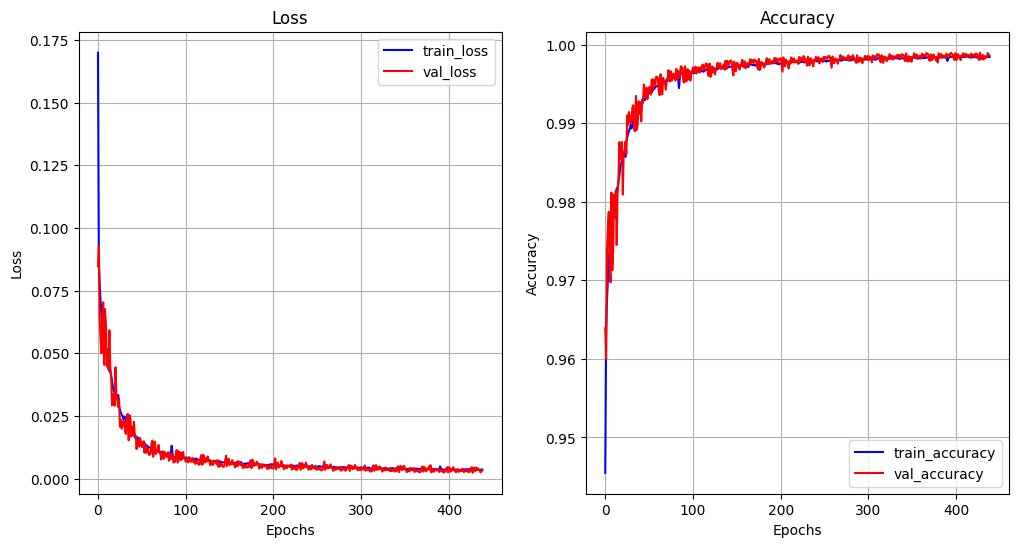

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드
file_path = '/content/drive/MyDrive/실험/e/histories/training_history.csv'
history_df = pd.read_csv(file_path)

# 학습 기록 그래프 출력 함수
def plot_history(df):
  plt.figure(figsize=(12, 6))

  # 손실 그래프
  plt.subplot(1, 2, 1)
  plt.plot(df['epoch'], df['loss'], color='blue', label='train_loss')
  plt.plot(df['epoch'], df['val_loss'], color='red', label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  # 정확도 그래프
  plt.subplot(1, 2, 2)
  plt.plot(df['epoch'], df['accuracy'], color='blue', label='train_accuracy')
  plt.plot(df['epoch'], df['val_accuracy'], color='red', label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

# 그래프 출력
plot_history(history_df)

## 과소적합(Underfitting) / 과대적합(Overfitting)

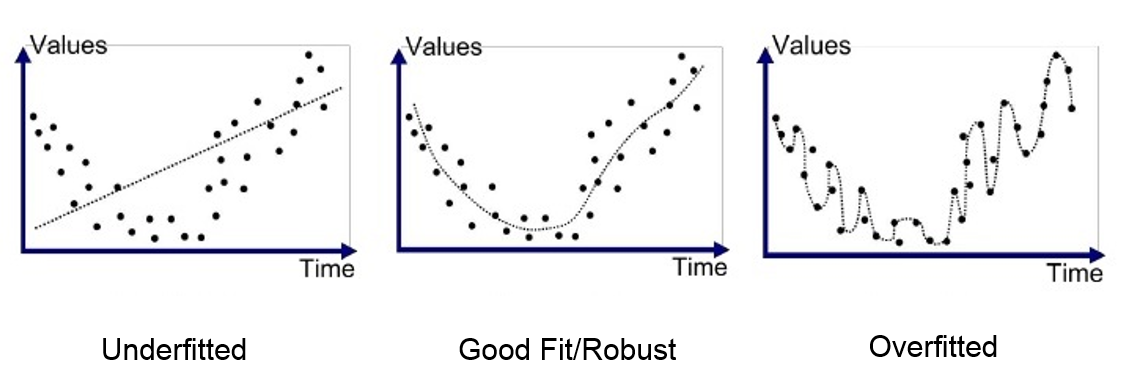

### 과소적합 (Underfitting)

- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋은 경우
- 모델이 지나치게 단순한 경우
- 해결 방안
  - 충분한 학습 데이터 수집
  - 보다 더 복잡한 모델 사용
  - 에폭수(epochs)를 늘려 충분히 학습

### 과대적합 (Overfitting)

- 모델이 학습 데이터에 지나치게 맞추어진 상태
- 새로운 데이터에서는 성능 저하
- 데이터에는 잡음이나 오류가 포함
- 학습 데이터가 매우 적을 경우
- 모델이 지나치게 복잡한 경우
- 학습 횟수가 매우 많을 경우
- 해결방안
  - 다양한 학습 데이터 수집 및 학습
  - 모델 단순화: 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄임
  - 정규화(Regularization)을 통한 규칙 단순화
  - 적정한 하이퍼 파라미터 찾기

### 과대적합(overfitting)과 과소적합(underfitting) 방지 방법

* 모델의 크기 축소
* 가중치 초기화(Weight Initializer)
* 옵티마이저(Optimizer)
* 배치 정규화(Batch Normalization)
* 규제화(Regularization)
* 드롭아웃(Dropout)

## 모델 평가 및 예측

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/drive/MyDrive/실험/e/model/model_epoch_427.h5') # 적절하게 경로 변경하시면 됩니다.
model.summary()

In [ ]:
!tar -xvf '/content/drive/MyDrive/test_images_labels_targets.tar' -C '/content/'

In [ ]:
input_dir = 'test/images'
target_dir = 'test/targets'
img_size = (1024,1024)
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

test_input_img_paths = input_img_paths
test_target_img_paths = target_img_paths

test_gen = xBD(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [ ]:
model.evaluate(test_gen)

933/933 [==============================] - 49s 50ms/step - loss: 0.2244 - accuracy: 0.9758


[0.22437173128128052, 0.9758090376853943]

In [ ]:
import math

# 추론용 데이터 제너레이터 클래스 정의
class xBDInference(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths

  def __len__(self):
    return math.ceil(len(self.input_img_paths) / self.batch_size)

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    return x


# 2. 테스트셋 이미지 모델 추론

In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

933/933 [==============================] - 41s 44ms/step


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
  mask = test_preds[i] > 0.5 # sigmoid 사용시
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 12

display(Image(filename=test_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)
display_mask(i)


Output hidden; open in https://colab.research.google.com to view.

## xBD 테스트셋 데이터 추론 마스크 결과 사진 저장

In [ ]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/실험/e/test_predicts_vgg16" # 경로 변경 필요
if not os.path.exists(save_dir):
  os.makedirs(save_dir)


In [ ]:
def save_mask(i, input_img_paths, save_dir):
  # 입력 이미지 경로에서 파일 이름 추출
  original_filename = os.path.basename(input_img_paths[i])
  # 파일 확장자 제거
  filename_without_extension = os.path.splitext(original_filename)[0]

  # 추론한 마스크 생성
  mask = test_preds[i] > 0.5 # sigmoid 사용시
  img = ImageOps.autocontrast(array_to_img(mask))

  # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
  save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

  # 생성된 마스크를 지정된 폴더에 저장
  img.save(save_path)

  print(f"Mask saved at: {save_path}")

In [ ]:
# test_preds에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(test_preds)):
  save_mask(i, test_input_img_paths, save_dir)

# MIOU 평가 (xBD test Data)



In [ ]:
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze() # 필요시 차원 축소
# 예측 레이블 준비

# 예측 확률이 0.5 이상인 경우 1로, 그렇지 않으면 0으로 설정
y_pred = (test_preds.squeeze() > 0.5).astype(int)  # 예측 결과 이진화
#y_pred = np.argmax(test_preds, axis=-1)

# mIoU 계산
def mean_iou(y_true, y_pred, num_classes):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)
  for i in range(num_classes):
    intersection[i] = np.logical_and(y_true == i, y_pred == i).sum()
    union[i] = np.logical_or(y_true == i, y_pred == i).sum()
  iou = intersection / np.maximum(union, 1)
  mIoU = np.mean(iou)
  return mIoU

miou_score = mean_iou(y_true, y_pred, num_classes)
print("Mean IoU for the test set is:", miou_score)

Mean IoU for the test set is: 0.9746635055503398


# F1 스코어

In [ ]:
from sklearn.metrics import f1_score

# 예측 레이블 준비 (이진 분류의 경우)
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze()  # 차원 축소, 결과는 0과 1의 레이블

# 예측 확률이 0.5 이상인 경우 1로, 그렇지 않으면 0으로 설정
y_pred = (test_preds.squeeze() > 0.5).astype(int)  # 예측 결과 이진화

# F1 스코어 계산
f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='binary')  # 이진 분류

print("F1 Score for the test set is:", f1)


F1 Score for the test set is: 0.7889823549533961


# 결과

### accuracy: 97.58%
### MIOU: 97.47
### F1 Score: 78.90

#DAICON 데이터셋

In [ ]:
!unzip -q "/content/drive/MyDrive/open.zip"

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/drive/MyDrive/실험/model/model_epoch_452.h5')
model.summary()

In [ ]:
input_dir = '/content/test_img'
img_size = (224, 224)
batch_size = 1

input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
])

test_input_img_paths = input_img_paths[:5000]


In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
  mask = test_preds[i] > 0.5 # sigmoid 사용시
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 930

display(Image(filename=test_input_img_paths[i]))
display_mask(i)
